<i>Anomaly Detection using Autoencoders</i><br>
--
AUTHOR BY :
* QIYA SAFIRA
* DANI JOHANES

Dataset <a href = "https://www.kaggle.com/nphantawee/pump-sensor-data">link</a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras import regularizers

In [10]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

class DataViz:
    @staticmethod
    def plot_loss(loss: ndarray, val_loss: ndarray, epochs: int):
        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
    @staticmethod
    def plot_learning_rate(learning_rate: ndarray, epochs: int):
        plt.figure()
        plt.plot(epochs, learning_rate, label='Learning Rate')
        plt.title('Learning Over Time')
        plt.legend()
        plt.show()

class Data:
    @staticmethod
    def flatten_data(data: ndarray) -> ndarray:
        if isinstance(data, ndarray):
            return data.flatten()
        return np.array(data).flatten()
    
    @staticmethod
    def normalize_data(data: ndarray, divide_factor: float) -> ndarray:
        if not isinstance(data, ndarray):
            data = np.array(data)
        return data / divide_factor

In [11]:
from keras.models import load_model, Model
import json

class ModelUtils:
    @staticmethod
    def load_model_from_disk(model_path: str):
        return load_model(model_path, compile=False)

    def save_model_to_disk(model, model_trained, model_name: str):
        print('Saving model to disk...')
        model.save('res/%s' % model_name)
        print('Saved')

        print('Saving loss history to disk...')
        json.dump(model_trained.history, open('res/%s.json' % model_name, 'w'))
        print('Saved')

In [12]:
import zipfile
zip_ref = zipfile.ZipFile('pump-sensor-data.zip', 'r')
zip_ref.extractall('Temporary')
zip_ref.close()

In [16]:
pump_data = pd.read_csv("Temporary/sensor.csv", sep=",")
pump_data.reset_index(drop=True, inplace=True)
pump_data = pump_data.drop(["Unnamed: 0"], axis=1)
display(pump_data)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,43.17085,54.16052,38.05424,13.265320,420.7993,NaN,463.2318,458.3615,2.499117,676.6655,405.7680,894.5920,543.5801,1109.5010,611.1745,700.5885,796.5964,692.1138,779.2067,485.0358,691.6666,974.9999,927.6135,477.3156,266.0334,578.5221,817.5707,0.00000,47.13541,29.16667,71.61458,30.468750,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,43.21038,54.52602,38.53485,13.242270,422.1567,NaN,463.1928,468.4388,2.618476,676.6547,406.2575,895.5599,541.7

In [17]:
pump_data = pump_data.fillna(pump_data.mean())
pump_data = pump_data.drop(["sensor_15"], axis=1)

In [18]:
pump_data

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.05560,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.05560,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.31940,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.45140,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.989580,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.18750,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,43.17085,54.16052,38.05424,13.265320,420.7993,463.2318,458.3615,2.499117,676.6655,405.7680,894.5920,543.5801,1109.5010,611.1745,700.5885,796.5964,692.1138,779.2067,485.0358,691.6666,974.9999,927.6135,477.3156,266.0334,578.5221,817.5707,0.00000,47.13541,29.16667,71.61458,30.468750,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,183.04926,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,43.21038,54.52602,38.53485,13.242270,422.1567,463.1928,468.4388,2.618476,676.6547,406.2575,895.5599,541.7014,1106.3710,609.4917,698.4915

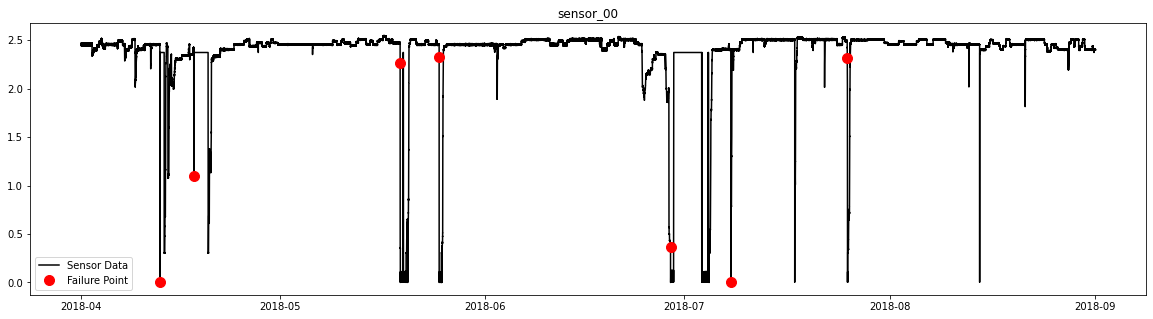

In [21]:
# Plot the figure

pd.options.mode.chained_assignment = None
broken_markers = pump_data[pump_data["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])
timestamps = list(pd.to_datetime(pump_data["timestamp"]).to_numpy())
pump_data_sensors_only = pump_data.drop(["machine_status", "timestamp"], axis=1)
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_00"], color="black", label="Sensor Data")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='o', color='red', markersize=10, label="Failure Point")
plt.title("sensor_00")
plt.legend()
plt.show()

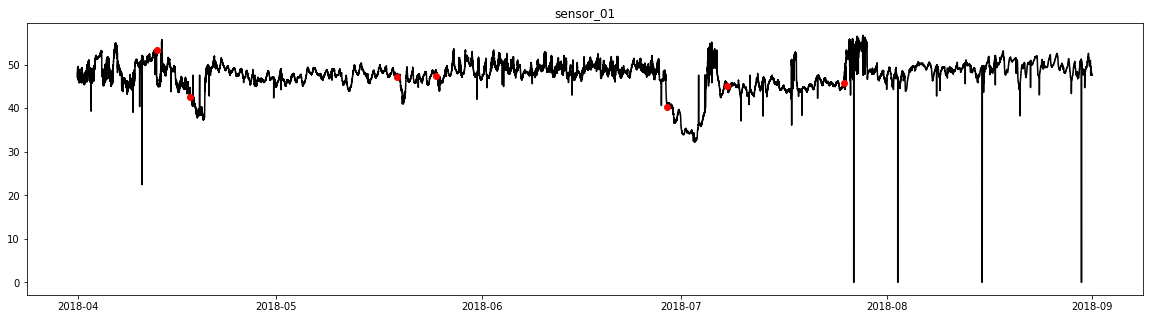

In [22]:
plt.figure(figsize=(20,5))
plt.plot(timestamps, pump_data_sensors_only["sensor_01"], color="black")
plt.plot(broken_markers["timestamp"], broken_markers["sensor_01"], linestyle='none', marker='o', color='red', markersize=6)
plt.title("sensor_01")
plt.show()

In [26]:
# Build the autoencoder!

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def flatten_all(input_data):
    new_data = []
    for data in input_data:
        new_data.append(data.flatten())
    return np.array(new_data)

def create_model(input_dim, encoder_layer_details, decoder_layer_details, optimizer, loss="mean_squared_error", metrics=None):
    input_layer = [Input(shape=(input_dim,), name="input")]
    output_layer = [Dense(units=input_dim, activation="sigmoid", name="output")]
    
    layers = input_layer + encoder_layer_details + decoder_layer_details + output_layer
    model = tf.keras.Sequential(layers)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

# Trains the model
def run_model(model, epochs, batch_size, x_train, x_test):
    model_train = model.fit(
        x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,
        validation_data=(x_test, x_test))
    DataViz.plot_loss(
        model_train.history['loss'],
        model_train.history['val_loss'],
        range(epochs)
    )
    
def find_and_plot_anomalies(model, x_train, x_test, original_dataset, pump_status, broken_markers):
    x_train_pred = model.predict(x_train)
    train_mse_loss = np.mean(np.square(np.abs(x_train_pred - x_train)), axis=1)

    plt.hist(train_mse_loss, bins=50)
    plt.xlabel("Train MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    threshold = np.max(train_mse_loss)
    print("Anomaly MSE threshold: ", threshold)
    x_test_pred = model.predict(x_test)
    test_mse_loss = np.mean(np.square(np.abs(x_test_pred - x_test)), axis=1)
    test_mse_loss = test_mse_loss.reshape((-1))

    plt.hist(test_mse_loss, bins=50)
    plt.xlabel("Test MSE loss")
    plt.ylabel("# of samples")
    plt.show()

    anomalies = test_mse_loss > threshold
    print("# of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    
    anomaly_points = original_dataset[original_dataset.index.isin(np.where(anomalies)[0])]
    plt.figure(figsize=(20,5))
    plt.plot(timestamps[part:], original_dataset["sensor_00"], color="black")
    plt.plot(broken_markers["timestamp"], broken_markers["sensor_00"], linestyle='none', marker='X', color='red', markersize=10)
    plt.plot(anomaly_points["timestamp"], anomaly_points["sensor_00"], linestyle='none', marker='o', color='blue', markersize=5)
    plt.title("sensor_00")
    plt.show()
    
    indexes = list(broken_markers.index)
    print(indexes)
    anomalies_indexes = list(np.where(anomalies)[0])
    total = len(anomalies_indexes)
    print("Total anomalies: %s" % (total))
    score = 0
    total_score = 0
    if total > 0:
        max_index = np.max(np.where(anomalies)[0])
        for idx, break_point in enumerate(indexes):
            next_lower_bound = max_index + 1
            current_lower_bound = break_point - 1440 if idx > 0 else 0
            valid_indexes = 0
            if idx < len(indexes) - 1:
                next_lower_bound = indexes[idx+1] - 1440
            for anomaly_index in anomalies_indexes:
                if anomaly_index < next_lower_bound and (anomaly_index >= current_lower_bound):
                    if (anomaly_index >= (break_point - 1440) and anomaly_index <= break_point) or (anomaly_index <= (break_point + 1440) and anomaly_index >= break_point):
                        score += 1
                    valid_indexes += 1
                    
            partial_score = ((score/valid_indexes)/len(indexes))*100 if valid_indexes > 0 else 0
            print(partial_score)
            total_score += partial_score
            score = 0
    
    return total_score

x_data = flatten_all(normalize(pump_data_sensors_only.to_numpy()))
part = 5*int(len(x_data)/10)
x_train = np.array(x_data[:part])
x_test = np.array(x_data[part:])

input_shape = x_train[0].shape[0]

original_dataset = pd.DataFrame({"sensor_00": x_train[:, 0], "timestamp": timestamps[part:]})
pump_status = pump_data[part:].reset_index(drop=True)
pump_status = pump_status[["machine_status", "timestamp"]]
pump_status = pd.concat([pd.DataFrame({"sensor_00": x_train[:, 0]}), pump_status], axis=1)
broken_markers = pump_status[pump_status["machine_status"] == "BROKEN"]
broken_markers["timestamp"] = pd.to_datetime(broken_markers["timestamp"])

epochs = 60
models = []

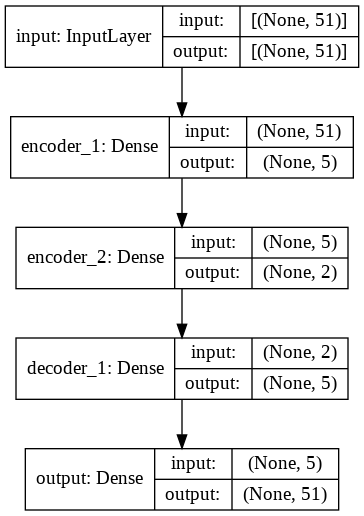

In [27]:
encoder_layer = [
    Dense(
        units=5,
        activation="relu",
        name="encoder_1"
    ),
    Dense(
        units=2,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=5,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 2/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 3/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 4/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/100
861/861 [==============================] - 3s 3ms/step - loss: 0.0013 - val_lo

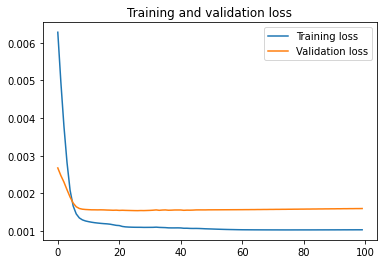

In [29]:
epochs = 100

run_model(models[-1], epochs, 128, x_train, x_test)

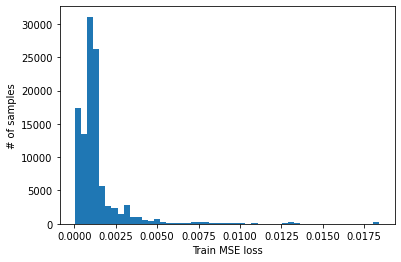

Anomaly MSE threshold:  0.01841047869630623


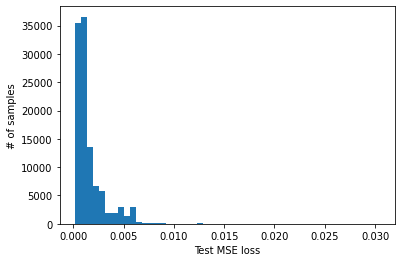

# of anomaly samples:  37
Indices of anomaly samples:  (array([17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17826,
       17827, 17828, 17829, 17830, 17846, 17848, 17849, 17850, 17851,
       17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906,
       17907, 17908, 17909, 17910, 17915, 17916, 17917, 17918, 17919,
       17920]),)


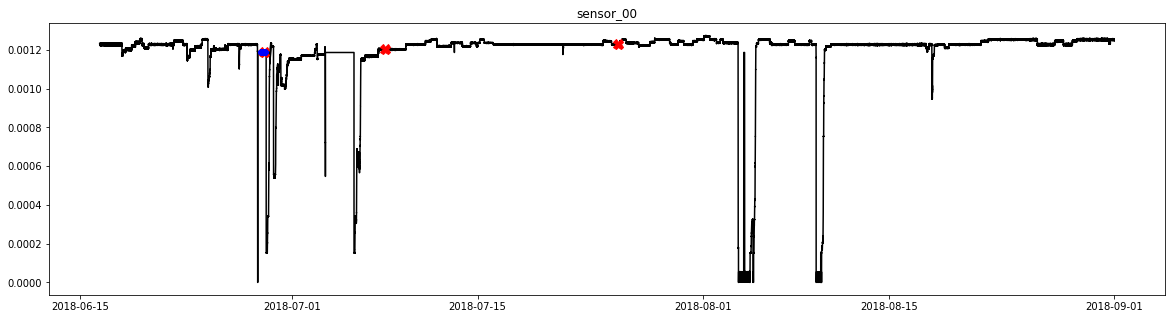

[17880, 30971, 56280]
Total anomalies: 37
33.33333333333333
0
0


33.33333333333333

In [30]:
score = find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)
score

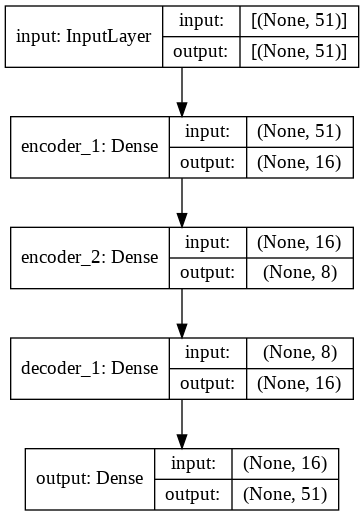

In [31]:
# Second model!

encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/150
861/861 [==============================] - 3s 3ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 2/150
861/861 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 3/150
861/861 [==============================] - 3s 3ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/150
861/861 [==============================] - 3s 3ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5/150
861/861 [==============================] - 3s 3ms/step - loss: 9.8762e-04 - val_loss: 0.0016
Epoch 6/150
861/861 [==============================] - 3s 3ms/step - loss: 9.8366e-04 - val_loss: 0.0016
Epoch 7/150
861/861 [==============================] - 3s 3ms/step - loss: 9.3824e-04 - val_loss: 0.0015
Epoch 8/150
861/861 [==============================] - 3s 3ms/step - loss: 9.0826e-04 - val_loss: 0.0015
Epoch 9/150
861/861 [==============================] - 3s 3ms/step - loss: 8.8166e-04 - val_loss: 0.0015
Epoch 10/150
861/861 [==============================] - 3s 3ms/step - l

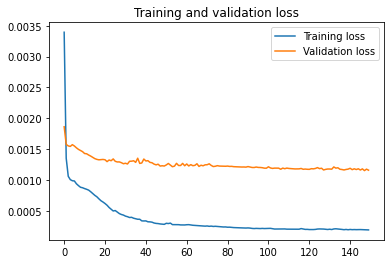

In [33]:
epochs = 150

run_model(models[-1], epochs, 128, x_train, x_test)

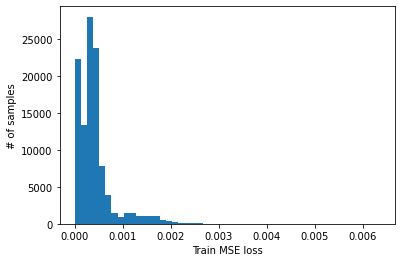

Anomaly MSE threshold:  0.00634788791493508


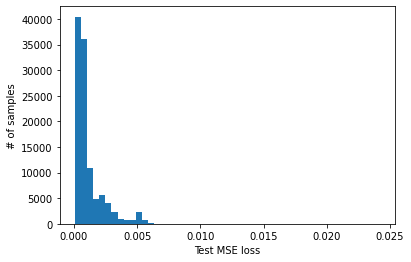

# of anomaly samples:  324
Indices of anomaly samples:  (array([14914, 15184, 15185, 15193, 15194, 15195, 15196, 15197, 15600,
       15601, 15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609,
       15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618,
       15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627,
       15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15636,
       15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645,
       15646, 15647, 15648, 15649, 15650, 17190, 17191, 17192, 17203,
       17204, 17205, 17208, 17209, 17210, 17213, 17214, 17215, 17216,
       17217, 17218, 17222, 17223, 17398, 17399, 17400, 17401, 17402,
       17403, 17430, 17431, 17432, 17433, 17447, 17448, 17449, 17458,
       17459, 17460, 17461, 17462, 17463, 17464, 17468, 17469, 17470,
       17471, 17472, 17473, 17481, 17482, 17483, 17484, 17485, 17503,
       17504, 17505, 17506, 17513, 17514, 17515, 17516, 17517, 17518,
       17519, 17523, 17524, 17525

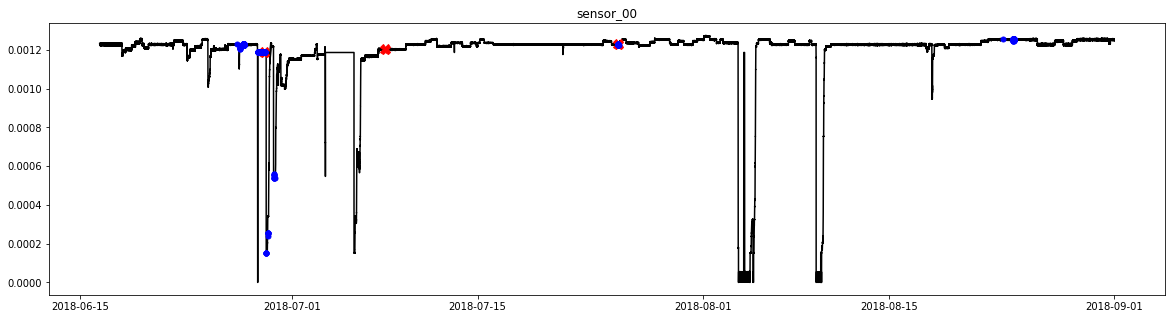

[17880, 30971, 56280]
Total anomalies: 324
25.172890733056708
0
5.622489959839357


30.795380692896064

In [34]:
# Plot them now 

find_and_plot_anomalies(models[-1], x_train, x_test, original_dataset, pump_status, broken_markers)

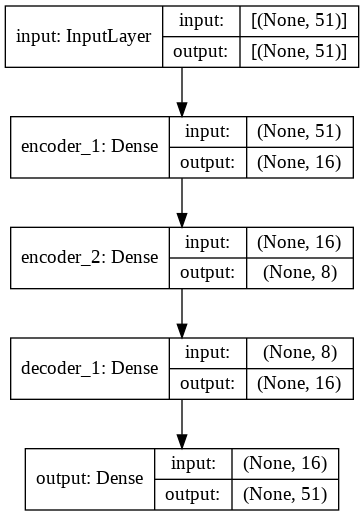

In [38]:
# Third model!

encoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_1"
    ),
    Dense(
        units=8,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="encoder_2"
    ),
]

decoder_layer = [
    Dense(
        units=16,
        activation="relu",
        activity_regularizer=regularizers.l1(1e-3),
        name="decoder_1"
    )
]

models.append(create_model(input_shape, encoder_layer, decoder_layer, "Adam"))
plot_model(models[-1], show_shapes=True)

Epoch 1/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0107 - val_loss: 0.0069
Epoch 2/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 3/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 4/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 5/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 6/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 7/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/100
861/861 [==============================] - 3s 4ms/step - loss: 0.0024 - val_lo

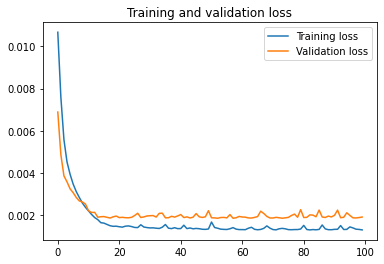

In [40]:
epochs = 100

run_model(models[-1], epochs, 128, x_train, x_test)